# Прогноз заработной платы по описанию вакансии


Проект подготовлен на основании информации о вакансиях, представленной на сайте https://career.habr.com/. Целью проекта является создание парсера для получения описания вакансий с данного сайта и создание модели, предсказывающей заработную плату на основании полученной информации

## 1. Парсинг данных
### 1.1 Подготовка

Доступ к веб-станицам позволяет получать модуль `requests` 

In [ ]:
import requests      
import numpy as np   
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import time         

Для наших исследовательских целей нужно собрать данные по каждой вакнсии с соответствующей ей страницы. Но для начала нужно получить адреса этих страниц. Поэтому открываем основную страницу со всеми выложенными вакансиями. Поскольку нас интересует предсказание зарплаты, оставим только те вакансии, где она указана.
Сохраним в переменную `page_link` адрес основной страницы и откроем её при помощи библиотеки `requests`.

In [ ]:
page_link = 'https://career.habr.com/vacancies?type=all&with_salary=true'# 1-я страница 
#https://career.habr.com/vacancies?page=2&type=all&with_salary=1 2-я страница
#https://career.habr.com/vacancies?page=3&type=all&with_salary=1 3-я страница

Воспользуемся генерацией фейкового юзер-агента, например [`fake-useragent`](https://pypi.python.org/pypi/fake-useragent). При вызове метода из различных кусочков будет генерироваться рандомное сочетание операционной системы, спецификаций и версии браузера, которые можно передавать в запрос:

In [ ]:
!pip install fake_useragent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.2 MB/s 


In [ ]:
# подгрузим один из методов этой библиотеки
from fake_useragent import UserAgent

In [ ]:
UserAgent().chrome

'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/532.0 (KHTML, like Gecko) Chrome/4.0.206.1 Safari/532.0'

In [ ]:
UserAgent().safari

'Mozilla/5.0 (Windows; U; Windows NT 5.1; ja-JP) AppleWebKit/525.27.1 (KHTML, like Gecko) Version/3.2.1 Safari/525.27.1'

In [ ]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

Мы получили ответ 200, а значит соединение установлено и данные получены.

In [ ]:
html = response.content

In [ ]:
len(html)

246180

In [ ]:
type(html)

bytes

### 1.2 BeautifulSoup

Восползуемся библиотекой BeautifulSoup, которая из сырого и необработанного HTML кода страницы выдаст нам структурированный массив данных, по которому очень удобно искать необходимые теги, классы, атрибуты, тексты и прочие элементы веб страниц.


In [ ]:
from bs4 import BeautifulSoup

Передадим функции `BeautifulSoup` текст веб-страницы, которую мы недавно получили.

In [ ]:
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
type(soup)

bs4.BeautifulSoup

In [ ]:
print(soup.prettify()[:1000])

<!DOCTYPE html>
<html lang="ru">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <title>
   Работа и свежие вакансии для IT специалистов от прямых работодателей — Хабр Карьера
  </title>
  <meta content="Работа и свежие вакансии для IT специалистов в самых разных сферах IT-индустрии: программирование, верстка, дизайн, менеджмент, веб-аналитика, маркетинг и других." name="description"/>
  <meta content="Работа и свежие вакансии для IT специалистов от прямых работодателей — Хабр Карьера" property="og:title"/>
  <meta content="Работа и свежие вакансии для IT специалистов в самых разных сферах IT-индустрии: программирование, верстка, дизайн, менеджмент, веб-аналитика, маркетинг и других." property="og:description"/>
  <meta content="https://career.habr.com/images/career_share.png" property="og:image"/>
  <meta content="Работа и свежие вакансии для IT специалистов от прямых работодателей — Хабр Карьера" name="twitter:title"/>
  <me

Найдем ссылки, которые ведут с главной страницы на вакансии

In [ ]:
obj = soup.find(lambda tag: tag.name == 'a' and tag.get('class') == ['vacancy-card__title-link'])
obj

<a class="vacancy-card__title-link" href="/vacancies/1000107505">Инженер по информационной безопасности</a>

In [ ]:
type(obj)

bs4.element.Tag

Полученный после поиска объект также обладает структурой bs4. Поэтому можно продолжить искать нужные нам объекты уже в нём. Вытащим ссылку на эту вакансию. Сделать это можно по атрибуту `href`, в котором лежит наша ссылка. 

In [ ]:
obj.attrs['href']

'/vacancies/1000107505'

После всех преобразований у данных поменялся тип. Теперь они `str`. Это означет, что с ними можно работать как с текстом и пускать в ход для отсеивания лишней информации регулярные выражения. 

In [ ]:
print("Тип данных до вытаскивания ссылки:", type(obj))
print("Тип данных после вытаскивания ссылки:", type(obj.attrs['href']))

Тип данных до вытаскивания ссылки: <class 'bs4.element.Tag'>
Тип данных после вытаскивания ссылки: <class 'str'>


Если несколько элементов на странице обладают указанным адресом, то метод `find` вернёт только самый первый.  Чтобы найти все элементы с таким адресом, нужно использовать метод `findAll`, и на выход будет выдан список. Таким образом, мы можем получить одним поиском сразу все объекты, содержащие ссылки на страницы с вакансиями.

In [ ]:
vacansy_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['vacancy-card__title-link'])
vacansy_links[:3]

[<a class="vacancy-card__title-link" href="/vacancies/1000107505">Инженер по информационной безопасности</a>,
 <a class="vacancy-card__title-link" href="/vacancies/1000108645">Инженер по сетевой безопасности</a>,
 <a class="vacancy-card__title-link" href="/vacancies/1000114559">Senior iOS Developer</a>]

In [ ]:
len(vacansy_links)

25

Осталось очистить полученный список от мусора:

In [ ]:
vacansy_links = [link.attrs['href'] for link in vacansy_links]

In [ ]:
vacansy_links[:10]

['/vacancies/1000107505',
 '/vacancies/1000108645',
 '/vacancies/1000114559',
 '/vacancies/1000114864',
 '/vacancies/1000114551',
 '/vacancies/1000112482',
 '/vacancies/1000114717',
 '/vacancies/1000105546',
 '/vacancies/1000113950',
 '/vacancies/1000114129']

In [ ]:
len(vacansy_links)

25

Мы получили ровно 25 ссылок по числу вакансий на одной странице поиска. 
Остался последний момент. Когда мы скачаем все вакансии с текущей страницы, нам нужно будет перейти на следующую. 

Обернем в функцию все преобразования, проделанные выше:

In [ ]:
def getPageLinks(page_number):
    """
        Возвращает список ссылок на мемы, полученный с текущей страницы
        
        page_number: int/string
            номер страницы для парсинга
            
    """
    # составляем ссылку на страницу поиска
    page_link = 'https://career.habr.com/vacancies?page={}&type=all&with_salary=1'.format(page_number)
    
    # запрашиваем данные по ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    
    if not response.ok:
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        return [] 
    
    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    
    # наконец, ищем ссылки на мемы и очищаем их от ненужных тэгов
    vacansy_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['vacancy-card__title-link'])
    vacansy_links = ['https://career.habr.com' + link.attrs['href'] for link in vacansy_links]
    
    return vacansy_links

Протестируем функцию и убедимся, что всё хорошо

In [ ]:
vacansy_links = getPageLinks(1)
vacansy_links[:2]

['https://career.habr.com/vacancies/1000107505',
 'https://career.habr.com/vacancies/1000108645']

In [ ]:
vacansy_links = getPageLinks(2)
vacansy_links[:2]

['https://career.habr.com/vacancies/1000100266',
 'https://career.habr.com/vacancies/1000113600']

Отлично, функция работает и теперь мы теоретически можем достать ссылки на все вакансии, для чего нам придется пройтись по 27 страницам. Перед этим посмотрим, как доставать всю необходимую информацию о конкретной вакансии. 

### 1.3 Сбор информации с каждой страницы 

Для начала сохраним ссылку на страницу в переменную и вытащим по ней контент.

In [ ]:
vacancy_page = 'https://career.habr.com/vacancies/1000070949'

response = requests.get(vacancy_page, headers={'User-Agent': UserAgent().chrome})

html = response.content
soup = BeautifulSoup(html,'html.parser')

In [ ]:
soup

<!DOCTYPE html>
<html lang="ru"><head><meta charset="utf-8"/><meta content="width=device-width, initial-scale=1" name="viewport"/><title>Вакансия «Middle QA engineer », удаленно, работа в компании «BnBerry» — Хабр Карьера</title>
<meta content="Вакансия «Middle QA engineer », удаленно, работа в компании «BnBerry». Полная занятость. Можно удаленно. Вакансия в архиве." name="description"/>
<meta content="Вакансия «Middle QA engineer », удаленно, работа в компании «BnBerry» — Хабр Карьера" property="og:title"/>
<meta content="Вакансия «Middle QA engineer », удаленно, работа в компании «BnBerry». Полная занятость. Можно удаленно. Вакансия в архиве." property="og:description"/>
<meta content="https://habrastorage.org/getpro/moikrug/uploads/company/100/007/028/1/logo/medium_ecb79f4255fb4aa8fe1e03011b6d6055.png" property="og:image"/>
<meta content="Вакансия «Middle QA engineer », удаленно, работа в компании «BnBerry» — Хабр Карьера" name="twitter:title"/>
<meta content="Вакансия «Middle QA en

найдем информацию о названии вакансии

In [ ]:
vacancy = soup.find('h1', attrs={'class':'page-title__title'})
vacancy

<h1 class="page-title__title">Middle QA engineer </h1>

In [ ]:
type(vacancy)

bs4.element.Tag

In [ ]:
vacancy.text

'Middle QA engineer '

Возьмем информацию о нашем целевом признаке - зарплате

In [ ]:
salary = soup.find('div', attrs={'class':'basic-salary--appearance-vacancy-header'})
salary 

<div class="basic-salary basic-salary--appearance-vacancy-header">до 2000 $</div>

In [ ]:
salary = salary.text

In [ ]:
salary

'до 2000 $'

перейдем к описанию вакансии, в данном проекте это будет основным признаком, на основании которого мы будем строить наше предсказание

In [ ]:
requirements = soup.find('div', attrs={'class':'style-ugc'})
requirements

<div class="style-ugc"><p>Американская компания BnBerry ищет инженера по контролю качества среднего уровня для работы над передовым проектом бронирования отелей.</p>
<p>Мы создаем инновационные продукты в индустрии туристических технологий, которые помогают отелям подключать новые каналы продаж, общаться с гостями и управлять контентом. Среди наших клиентов - крупные международные отели и курорты, а также независимые отели в США. В 2022 году мы выходим на рынки Латинской Америки, Канады и Европы.</p>
<p>Инструменты и сервисы BnBerry используются отелями для подключения к гостиничным рынкам, управления распределением запасов, бронированиями, доходами и обслуживанием клиентов. В нашем портфолио представлены лучшие международные отели и курорты, а также независимые и франчайзинговые отели.</p>
<p><strong>Основные обязанности:</strong></p>
<ul><li>Помощь в определении методологии тестирования, критерий и тестовых примеров, необходимых для проверки критической функциональности</li><li>Выявл

In [ ]:
for br in requirements('br'):
    br.replace_with('\n')

In [ ]:
type(requirements)

bs4.element.Tag

In [ ]:
#requirements.br.extend(" ")

In [ ]:
requirements

<div class="style-ugc"><p>Американская компания BnBerry ищет инженера по контролю качества среднего уровня для работы над передовым проектом бронирования отелей.</p>
<p>Мы создаем инновационные продукты в индустрии туристических технологий, которые помогают отелям подключать новые каналы продаж, общаться с гостями и управлять контентом. Среди наших клиентов - крупные международные отели и курорты, а также независимые отели в США. В 2022 году мы выходим на рынки Латинской Америки, Канады и Европы.</p>
<p>Инструменты и сервисы BnBerry используются отелями для подключения к гостиничным рынкам, управления распределением запасов, бронированиями, доходами и обслуживанием клиентов. В нашем портфолио представлены лучшие международные отели и курорты, а также независимые и франчайзинговые отели.</p>
<p><strong>Основные обязанности:</strong></p>
<ul><li>Помощь в определении методологии тестирования, критерий и тестовых примеров, необходимых для проверки критической функциональности</li><li>Выявл

In [ ]:
requirements = requirements.text.replace('\n', ' ')

In [ ]:
requirements

'Американская компания BnBerry ищет инженера по контролю качества среднего уровня для работы над передовым проектом бронирования отелей. Мы создаем инновационные продукты в индустрии туристических технологий, которые помогают отелям подключать новые каналы продаж, общаться с гостями и управлять контентом. Среди наших клиентов - крупные международные отели и курорты, а также независимые отели в США. В 2022 году мы выходим на рынки Латинской Америки, Канады и Европы. Инструменты и сервисы BnBerry используются отелями для подключения к гостиничным рынкам, управления распределением запасов, бронированиями, доходами и обслуживанием клиентов. В нашем портфолио представлены лучшие международные отели и курорты, а также независимые и франчайзинговые отели. Основные обязанности: Помощь в определении методологии тестирования, критерий и тестовых примеров, необходимых для проверки критической функциональностиВыявление дефектов и написание четких и воспроизводимых отчетов об ошибках в соответствии

также добавим информацию о компании

In [ ]:
company = soup.find('div', attrs={'class':'vacancy-company__title'})
company

<div class="vacancy-company__title"><a class="basic-avatar basic-avatar--size-extra-small basic-avatar--roundness-small" href="/companies/bnberry"><img alt="Логотип компании «BnBerry»" class="basic-avatar__image" src="https://habrastorage.org/getpro/moikrug/uploads/company/100/007/028/1/logo/ecb79f4255fb4aa8fe1e03011b6d6055.png"/></a><a class="link-comp link-comp--appearance-dark" href="/companies/bnberry">BnBerry</a></div>

In [ ]:
company = company.text

In [ ]:
company

'BnBerry'

объединим все в общую функцию

In [ ]:
def getVacancyData(vacancy_page):
    """
        Запрашивает данные по странице, возвращает обработанный словарь с данными
        
        vacancy_page: string
            ссылка на страницу с вакансией
    
    """
    
    # запрашиваем данные по ссылке
    response = requests.get(vacancy_page, headers={'User-Agent': UserAgent().chrome})
    
    if not response.ok:
        # если сервер нам отказал, вернем статус ошибки 
        return response.status_code
    
    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # используя ранее написанные функции парсим информацию
    vacancy = (soup.find('h1', attrs={'class':'page-title__title'})).text
    salary = (soup.find('div', attrs={'class':'basic-salary--appearance-vacancy-header'})).text
    requirements = (soup.find('div', attrs={'class':'style-ugc'}))
    for br in requirements('br'):
        br.replace_with('\n')
    requirements = requirements.text.replace('\n', ' ')
    company = (soup.find('div', attrs={'class':'vacancy-company__title'})).text

    # составляем словарь, в котором будут хранится все полученные и обработанные данные
    data_row = {"vacancy":vacancy, "salary":salary, 
                "requirements":requirements, "company":company}


    return data_row

In [ ]:
data_row = getVacancyData('https://career.habr.com/vacancies/1000070949')

In [ ]:
data_row

{'vacancy': 'Middle QA engineer ',
 'salary': 'до 2000 $',
 'requirements': 'Американская компания BnBerry ищет инженера по контролю качества среднего уровня для работы над передовым проектом бронирования отелей. Мы создаем инновационные продукты в индустрии туристических технологий, которые помогают отелям подключать новые каналы продаж, общаться с гостями и управлять контентом. Среди наших клиентов - крупные международные отели и курорты, а также независимые отели в США. В 2022 году мы выходим на рынки Латинской Америки, Канады и Европы. Инструменты и сервисы BnBerry используются отелями для подключения к гостиничным рынкам, управления распределением запасов, бронированиями, доходами и обслуживанием клиентов. В нашем портфолио представлены лучшие международные отели и курорты, а также независимые и франчайзинговые отели. Основные обязанности: Помощь в определении методологии тестирования, критерий и тестовых примеров, необходимых для проверки критической функциональностиВыявление деф

подготовим датафрейм, куда будем добавлять всю полученную информацию

In [ ]:
final_df = pd.DataFrame(columns=['vacancy', 'salary', 'requirements', 'company'])

In [ ]:
final_df = final_df.append(data_row, ignore_index=True)

In [ ]:
final_df

,vacancy,salary,requirements,company
0,Middle QA engineer,до 2000 $,Американская компания BnBerry ищет инженера по...,BnBerry


Еще раз убедимся что всё работает — пройдемся по списку из ссылок на вакансии, полученных ранее в перменной `vacancy_links`.

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
vacansy_links

['https://career.habr.com/vacancies/1000100266',
 'https://career.habr.com/vacancies/1000113600',
 'https://career.habr.com/vacancies/1000084876',
 'https://career.habr.com/vacancies/1000082657',
 'https://career.habr.com/vacancies/1000110988',
 'https://career.habr.com/vacancies/1000102076',
 'https://career.habr.com/vacancies/1000102075',
 'https://career.habr.com/vacancies/1000114839',
 'https://career.habr.com/vacancies/1000114838',
 'https://career.habr.com/vacancies/1000114834',
 'https://career.habr.com/vacancies/1000114832',
 'https://career.habr.com/vacancies/1000114015',
 'https://career.habr.com/vacancies/1000114012',
 'https://career.habr.com/vacancies/1000114526',
 'https://career.habr.com/vacancies/1000113562',
 'https://career.habr.com/vacancies/1000114075',
 'https://career.habr.com/vacancies/1000102426',
 'https://career.habr.com/vacancies/1000113160',
 'https://career.habr.com/vacancies/1000096732',
 'https://career.habr.com/vacancies/1000114829',
 'https://career.hab

In [ ]:
for vacansy_link in tqdm_notebook(vacansy_links):
    try: 
        data_row = getVacancyData(vacansy_link)
        final_df = final_df.append(data_row, ignore_index=True)
        time.sleep(0.4)
    except:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
final_df.drop_duplicates(inplace=True)

In [ ]:
final_df.shape

(26, 4)

In [ ]:
final_df.head()

,vacancy,salary,requirements,company
0,Middle QA engineer,до 2000 $,Американская компания BnBerry ищет инженера по...,BnBerry
1,Fullstack Node.js / React Developer 🔥,от 2500 до 4500 $,Ищем Fullstack Node.js/React Developer (верста...,Fundraise Up
2,Head of Product Support 🔥,от 3000 до 4500 $,Ищем хеда саппорт-команды на удаленную работу ...,Fundraise Up
3,Дизайнер интерфейсов уровня middle,от 2500 до 3000 $,"Self - студия дизайна, брендинга и разработки ...",Self Studio
4,Python developer (Middle),от 300 000 до 360 000 ₽,Python разработчик (Middle) с опытом работы от...,.White Code


In [ ]:
from tqdm import tqdm_notebook


final_df = pd.DataFrame(columns=['vacancy', 'salary', 'requirements', 'company'])

for page_number in tqdm_notebook(range(29), desc='Pages'):
    vacancy_links = getPageLinks(page_number)  
    for vacancy_link in tqdm_notebook(vacancy_links, leave=False):
        # иногда с первого раза страничка не парсится
        for i in range(3):
            try:
                # пытаемся собрать по мему немного даты
                data_row = getVacancyData(vacancy_link)           
                # и закидываем её в таблицу
                final_df = final_df.append(data_row, ignore_index=True)  
                # если всё получилось - выходим из внутреннего цикла
                break
            except:
                # Иначе, пробуем еще несколько раз, пока не закончатся попытки
                print('AHTUNG! parsing once again:', vacancy_link)
                continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Pages:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
final_df.head(10)

,vacancy,salary,requirements,company
0,Инженер по информационной безопасности,до 250 000 ₽,С целью предотвращения внешних и внутренних уг...,АО «ГНИВЦ»
1,Инженер по сетевой безопасности,от 200 000 до 230 000 ₽,С целью предотвращения внешних и внутренних уг...,АО «ГНИВЦ»
2,Senior iOS Developer,от 2500 до 3500 $,Требуемый опыт работы: 3–6 лет Полная занятост...,TodayVideoApp
3,Инженер по нагрузочному тестированию (QA Perfo...,от 250 000 ₽,Приглашаем инженера по нагрузочному тестирован...,SberTech
4,Java developer (Platform V Product 360),до 320 000 ₽,Platform V Product 360 — это облачное решение ...,SberTech
5,С++ OpenCV,от 200 000 до 250 000 ₽,Проект — разработка системы управления рентген...,ALT-CRAFT
6,PHP backend разработчик,от 150 000 ₽,Trivio - это онлайн-сервис организации команди...,Тривио
7,Бекенд-программист / Backend-developer/ Golang...,от 130 000 до 180 000 ₽,Что нужно делать: Разрабатывать бэкэнд (для ве...,Soft Skills
8,Python Backend Developer (Team Lead/Remote),до 350 000 ₽,JetLend - инвестиционная платформа в индустрии...,JetLend
9,Ведущий программист-разработчик 1С,от 250 000 ₽,ОСГ Рекордз Менеджмент – единственная федераль...,ОСГ Рекордз Менеджмент


In [ ]:
len(final_df)

725

Сохраним полученные данные в csv для дальнейшей работы с ними

In [ ]:
final_df.to_csv("habr_parsing_.csv")

За время подготовки итогового проекта, парсер запускался несколько раз, таким образом получилось собрать 2100 вакансий

In [1]:
from google.colab import files

uploaded = files.upload()

Saving habr_parsing_final_.csv to habr_parsing_final_.csv


In [2]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded["habr_parsing_final_.csv"]), on_bad_lines='skip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2100 non-null   int64 
 1   vacancy       2100 non-null   object
 2   salary        2100 non-null   object
 3   requirements  2100 non-null   object
 4   company       2100 non-null   object
dtypes: int64(1), object(4)
memory usage: 82.2+ KB


In [3]:
df.head(10)

,Unnamed: 0,vacancy,salary,requirements,company
0,0,Разработчик GO,от 4000 $,Работа в лондонской Prop-tech компании в коман...,Genue
1,1,Fullstack-разработчик,от 120 000 ₽,"Привет! Мы компания html academy, школа профес...",html academy
2,2,Ведущий программист микроконтроллеров,от 160 000 ₽,Наша компания занимается разработкой приборов ...,Portlab
3,3,JavaScript Team Lead,от 170 000 ₽,"Привет. Мы — html academy, школа профессиональ...",html academy
4,4,Разработчик-репетитор на курс «Node.js. Проект...,от 20 000 до 40 000 ₽,Задача HTML Academy — сделать из любого новичк...,html academy
5,5,Разработчик-репетитор на курс «JavaScript. Арх...,от 20 000 до 45 000 ₽,Задача HTML Academy — сделать из любого новичк...,html academy
6,6,Разработчик-репетитор на курс «Node.js Професс...,от 20 000 до 45 000 ₽,Задача HTML Academy — сделать из любого новичк...,html academy
7,7,Senior Data Engineer / DWH Team,до 450 000 ₽,Сердце отдела анализа данных - решения и проду...,KazanExpress
8,8,Senior Data Engineer / DWH Team,от 300 000 до 450 000 ₽,Сердце отдела анализа данных - решения и проду...,KazanExpress
9,9,Senior Product Analyst,от 230 000 до 280 000 ₽,В центре нашей культуры - аналитика. Мы постоя...,KazanExpress


## 2. Предобработка данных

### 2.1 Предобработка целевого признака

Запралата указана как в рублях, так и в долларах. Приведем ее к рублям. Официальный курс на начало подготовки проекта 
(11.10.2022) - 62,31. Кроме того воспользуемся регулярными выражениями, чтобы оставить только число. Если для зарплаты указан диапазон, возьмем только левую границу.

In [4]:
import re

In [5]:
#напишем функцию, которая переводит доллары в рубли и оставляет только численные значения
def total_salary(row):
    row['salary'] = row['salary'].split(' ', maxsplit = 1)[1]
    if '$' in row['salary']:
        return round(int(re.sub(r'[^\d/]', '', row['salary'].split('до')[0]))*62.31)
    else:
        return int(re.sub(r'[^\d/]', '', row['salary'].split('до')[0]))

In [6]:
df['salary'] = df.apply(total_salary, axis = 1)
df.head(10)

,Unnamed: 0,vacancy,salary,requirements,company
0,0,Разработчик GO,249240,Работа в лондонской Prop-tech компании в коман...,Genue
1,1,Fullstack-разработчик,120000,"Привет! Мы компания html academy, школа профес...",html academy
2,2,Ведущий программист микроконтроллеров,160000,Наша компания занимается разработкой приборов ...,Portlab
3,3,JavaScript Team Lead,170000,"Привет. Мы — html academy, школа профессиональ...",html academy
4,4,Разработчик-репетитор на курс «Node.js. Проект...,20000,Задача HTML Academy — сделать из любого новичк...,html academy
5,5,Разработчик-репетитор на курс «JavaScript. Арх...,20000,Задача HTML Academy — сделать из любого новичк...,html academy
6,6,Разработчик-репетитор на курс «Node.js Професс...,20000,Задача HTML Academy — сделать из любого новичк...,html academy
7,7,Senior Data Engineer / DWH Team,450000,Сердце отдела анализа данных - решения и проду...,KazanExpress
8,8,Senior Data Engineer / DWH Team,300000,Сердце отдела анализа данных - решения и проду...,KazanExpress
9,9,Senior Product Analyst,230000,В центре нашей культуры - аналитика. Мы постоя...,KazanExpress


Посмотрим на макисмальные и минимальные значения заработной платы

In [ ]:
df['salary'].unique().max()

3115500

In [ ]:
df['salary'].unique().min()

1000

In [7]:
#напишем функцию, которая присвоит категории в зависимости от зарплаты с диапазоном 100000
def total_salary_cat(row):
    if row['salary'] < 100000:
        return 0
    elif row['salary'] < 200000:
        return 1
    elif row['salary'] < 300000:
        return 2
    elif row['salary'] < 400000:
        return 3
    else:
        return 4

In [8]:
df['salary_cat'] = df.apply(total_salary_cat, axis = 1)
df.head()

,Unnamed: 0,vacancy,salary,requirements,company,salary_cat
0,0,Разработчик GO,249240,Работа в лондонской Prop-tech компании в коман...,Genue,2
1,1,Fullstack-разработчик,120000,"Привет! Мы компания html academy, школа профес...",html academy,1
2,2,Ведущий программист микроконтроллеров,160000,Наша компания занимается разработкой приборов ...,Portlab,1
3,3,JavaScript Team Lead,170000,"Привет. Мы — html academy, школа профессиональ...",html academy,1
4,4,Разработчик-репетитор на курс «Node.js. Проект...,20000,Задача HTML Academy — сделать из любого новичк...,html academy,0


Посмотрим, как распределены категории

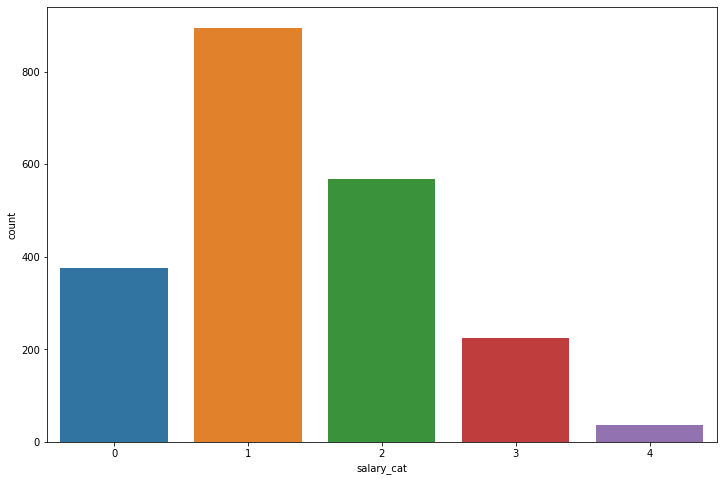

In [ ]:
plt.subplots(figsize=(12, 8))
ax = sns.countplot(x=df["salary_cat"])
plt.show()

Отложим 10% данных для тестирования модели 

In [9]:
df_test = df[:210]
df = df[210:]

In [11]:
# получим список предложений и их лейблов
sentences = df.requirements.values
labels = df.salary_cat.values

## 3. Обучение модели

### 3.1 Обучение модели на основании описания вакансии

In [12]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.0 MB/s 
     |████████████████████████████████| 7.6 MB 65.1 MB/s 
     |████████████████████████████████| 182 kB 85.8 MB/s 


В данном проекте использована предобученная языковая модель BERT из библиотеки huggingface PyTorch. Я использовала мультиязычную модель "BERT multilingual base model (cased)", поскольку в качестве данных использованы вакансии it-специальностей, названия и описания которых помимо русского содержат английский язык.

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

model = AutoModelForMaskedLM.from_pretrained("bert-base-multilingual-cased")

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Применим токенайзер к одному предложению и посмотрим, что получится.

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Эксплуатация Web Application Firewall различных вендоров, а также NGFW, IPS; • Разбор инцидентов ИБ, создание и тюннинг профилей защиты; • Диагностика, траблшутинг проблем с производительностью и аварий на СЗИ; • Выявление и устранение уязвимостей защищаемых WEB-ресурсов; • Ввод в эксплуатацию новых СЗИ; • Участие в разработке мер, внесение предложений, направленных на повышение уровня информационной безопасности; • Документирование и поддержание в актуальном состоянии документации связанной с вверенными сетевыми СЗИ. 
Tokenized:  ['Э', '##кс', '##п', '##лу', '##ата', '##ция', 'Web', 'Application', 'Fire', '##wall', 'различных', 'в', '##енд', '##оров', ',', 'а', 'также', 'NG', '##F', '##W', ',', 'IP', '##S', ';', '•', 'Р', '##аз', '##бор', 'ин', '##ци', '##дент', '##ов', 'И', '##Б', ',', 'создание', 'и', 'т', '##ю', '##нни', '##нг', 'проф', '##иле', '##й', 'защиты', ';', '•', 'Д', '##иа', '##г', '##ности', '##ка', ',', 'т', '##ра', '##бл', '##шу', '##тин', '##г', 'проблем',

Найдем максимальную длину предложений, чтобы усечь все до одинаковой длины или оставить максимально возможную длину 512

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1888


Поскольку длина превышает 512, оставим максимально возможную.
Воспользуемся функцией tokenizer.encode_plus, которая разобьет предложения на токены, добавит специальные токены [CLS] и [SEP], заменит токены на их ID,приведет все предложения к одной длине - max_len и создаст attention masks.

In [ ]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Эксплуатация Web Application Firewall различных вендоров, а также NGFW, IPS; • Разбор инцидентов ИБ, создание и тюннинг профилей защиты; • Диагностика, траблшутинг проблем с производительностью и аварий на СЗИ; • Выявление и устранение уязвимостей защищаемых WEB-ресурсов; • Ввод в эксплуатацию новых СЗИ; • Участие в разработке мер, внесение предложений, направленных на повышение уровня информационной безопасности; • Документирование и поддержание в актуальном состоянии документации связанной с вверенными сетевыми СЗИ. 
Token IDs: tensor([   101,    538,  18705,  11078,  16111,  16962,  12942,  14636,  73238,
         16011,  33743,  27031,    543,  92154,  48569,    117,    541,  11448,
         68839,  11565,  13034,    117,  24124,  10731,    132,   1729,    525,
         26313,  20545,  27796,  12012,  87161,  10433,    517,  18683,    117,
         56875,    549,    559,  10593,  60267,  26720,  56619,  50751,  10384,
         51599,    132,   1729,    513,  97843,  1082

Разделим данные на train и val в пропорции 90% к 10%.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,701 training samples
  189 validation samples


Также создадим итератор с использование класса DataLoader из библиотеки torch.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Для этой задачи воспользуемся модифицированной весией преобученного BERT'а BertForSequenceClassification с дополнительным классификационным слоем поверх основной архитектуры.

In [ ]:
CUDA_LAUNCH_BLOCKING=1
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = 5, 
   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Зададим optimizer и sheduler

In [20]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Для обучения зададим 6 эпох

In [21]:
from transformers import get_linear_schedule_with_warmup


epochs = 6
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Воспользуемся вспомогательной функцией для вычисления точности и отслеживания затраченного времени

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        res = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            res = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels
                        )
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:02.
  Batch    80  of    107.    Elapsed: 0:02:06.

  Average training loss: 1.36
  Training epcoh took: 0:02:49

Running Validation...
  Accuracy: 0.45
  Validation Loss: 1.30
  Validation took: 0:00:07

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:05.
  Batch    80  of    107.    Elapsed: 0:02:10.

  Average training loss: 1.27
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.16
  Validation took: 0:00:07

======== Epoch 3 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:05.
  Batch    80  of    107.    Elapsed: 0:02:09.

  Average training loss: 1.11
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.03
  Validation took: 0:00:07

======== Epoch 4 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:05.
  Batch    80  of    107.    Elapsed: 0:

Посмотрим на получившиеся результаты

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.36,1.30,0.45,0:02:49,0:00:07
2,1.27,1.16,0.53,0:02:52,0:00:07
3,1.11,1.03,0.59,0:02:52,0:00:07
4,0.90,0.95,0.61,0:02:52,0:00:07
5,0.71,0.93,0.67,0:02:52,0:00:07
6,0.57,0.83,0.68,0:02:52,0:00:07


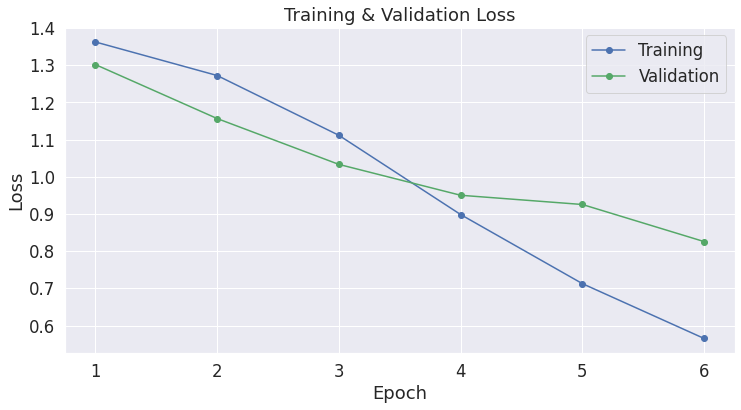

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

Мы видим, что loss как на обучении, так и на валидации непрерывно падает, это означает, что за 6 эпох модель не переобучилась. Значение Accuracy составло 0.68. Для улучшения качества, добавим в данные информацию о наименовании компании и должности и обучим новую модель

### 3.2 Обучение модели на основании описания вакансии, наименования должности и названия фирмы

Посмотрим, сможем ли мы получить более высокое качество, если добавим к описанию название вакансии и фирмы. Сделаем это с помошью специального токена [SEP]

In [10]:
df['all_description'] = df['company'] + '[SEP]' + df['vacancy']+ '[SEP]' + df['requirements']

In [11]:
df.head(10)

,Unnamed: 0,vacancy,salary,requirements,company,salary_cat,all_description
210,210,Инженер web ресурсов,150000,Эксплуатация Web Application Firewall различны...,Ростелеком,1,Ростелеком[SEP]Инженер web ресурсов [SEP]Экспл...
211,211,Инженер SIEM,150000,Что предстоит делать: Эксплуатация и развитие ...,Ростелеком,1,Ростелеком[SEP]Инженер SIEM[SEP]Что предстоит ...
212,212,"Frontend-разработчик, vue.js и knockout.js - ...",115000,В команду разработки крупного и интересного пр...,Paradox,1,"Paradox[SEP]Frontend-разработчик, vue.js и kn..."
213,213,Front (React) разработчик,150000,Что следует знать о нас: - У нас мало проектов...,FSD,1,FSD[SEP]Front (React) разработчик[SEP]Что след...
214,214,Middle Golang Developer,100000,Группа Компаний «BlackWallGroup» открывает наб...,Black Wall Group,1,Black Wall Group[SEP]Middle Golang Developer[S...
215,215,Ведущий инженер-программист в центр роботехник...,280000,Кто мы? Команда e-commerce робототехники Лабор...,Сбер,2,Сбер[SEP]Ведущий инженер-программист в центр р...
216,216,Senior System Analyst,180000,The international company Lanck Telecom is loo...,LANCK Telecom,1,LANCK Telecom[SEP]Senior System Analyst[SEP]Th...
217,217,Backend разработчик (sberbank.ru),220000,Наша команда поддерживает и развивает официаль...,Сбер,2,Сбер[SEP]Backend разработчик (sberbank.ru)[SEP...
218,218,Рекрутер,20000,Тебе предстоит: - Поиск кандидатов по нашим кр...,Black Wall Group,0,Black Wall Group[SEP]Рекрутер[SEP]Тебе предсто...
219,219,Data Engineer в Лабораторию Нейронаук и поведе...,220000,В поисках Middle Data Engineer (Data Scientist...,Сбер,2,Сбер[SEP]Data Engineer в Лабораторию Нейронаук...


In [14]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

model = AutoModelForMaskedLM.from_pretrained("bert-base-multilingual-cased")

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
sentences = df.all_description.values
labels = df.salary_cat.values

Аналогичным образом подготовим данные

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Ростелеком[SEP]Инженер web ресурсов [SEP]Эксплуатация Web Application Firewall различных вендоров, а также NGFW, IPS; • Разбор инцидентов ИБ, создание и тюннинг профилей защиты; • Диагностика, траблшутинг проблем с производительностью и аварий на СЗИ; • Выявление и устранение уязвимостей защищаемых WEB-ресурсов; • Ввод в эксплуатацию новых СЗИ; • Участие в разработке мер, внесение предложений, направленных на повышение уровня информационной безопасности; • Документирование и поддержание в актуальном состоянии документации связанной с вверенными сетевыми СЗИ. 
Token IDs: tensor([   101,    525,  33580,  31851,  13393,    102,  28146,  95211,  12998,
         70906,    102,    538,  18705,  11078,  16111,  16962,  12942,  14636,
         73238,  16011,  33743,  27031,    543,  92154,  48569,    117,    541,
         11448,  68839,  11565,  13034,    117,  24124,  10731,    132,   1729,
           525,  26313,  20545,  27796,  12012,  87161,  10433,    517,  18683,
           1

Разделим данные на train и val в пропорции 90% к 10%.

In [17]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,701 training samples
  189 validation samples


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [19]:
CUDA_LAUNCH_BLOCKING=1
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, 

    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [24]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        res = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            res = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels
                        )
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:02.
  Batch    80  of    107.    Elapsed: 0:02:07.

  Average training loss: 1.36
  Training epcoh took: 0:02:49

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.29
  Validation took: 0:00:07

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:05.
  Batch    80  of    107.    Elapsed: 0:02:09.

  Average training loss: 1.21
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.15
  Validation took: 0:00:07

======== Epoch 3 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:05.
  Batch    80  of    107.    Elapsed: 0:02:09.

  Average training loss: 0.97
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.92
  Validation took: 0:00:07

======== Epoch 4 / 6 ========
Training...
  Batch    40  of    107.    Elapsed: 0:01:05.
  Batch    80  of    107.    Elapsed: 0:

Посмотрим на получившиеся результаты

In [25]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.36,1.29,0.44,0:02:49,0:00:07
2,1.21,1.15,0.48,0:02:52,0:00:07
3,0.97,0.92,0.69,0:02:52,0:00:07
4,0.73,0.79,0.72,0:02:52,0:00:07
5,0.53,0.73,0.76,0:02:52,0:00:07
6,0.41,0.72,0.77,0:02:52,0:00:07


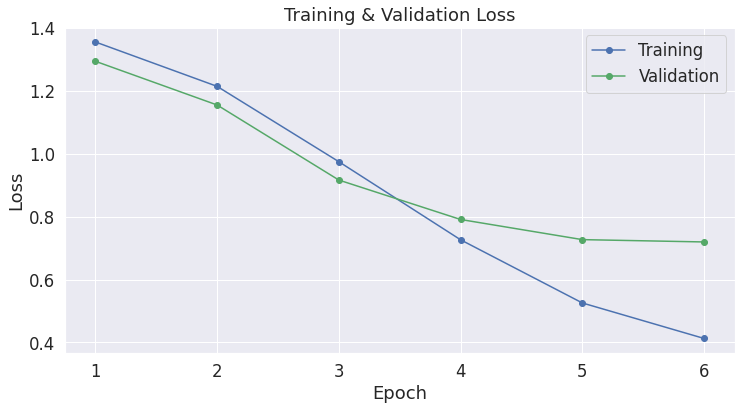

In [26]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

Мы видим, что качество стало гораздо выше с использованием наименования компании и должности. Loss на валидации после пятой эпохи не упал, таким образом мы не дошли до переобучения модели

## 4 Проверка на тестовых данных

Теперь проверим полученную модель на отложенной тестовой выборке

In [36]:
df_test['all_description'] = df_test['company'] + '[SEP]' + df_test['vacancy']+ '[SEP]' + df_test['requirements']

In [37]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#df = df_test
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df_test.all_description.values
labels = df_test.salary_cat.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,890



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


После того, как мы подготовили тестовые данные, сгенерируем предсказания с использованием дообученной модели.

In [38]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 210 test sentences...
    DONE.


Рассчитаем Accuracy для тестовой выборки

In [46]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [47]:
print(f'Accuracy на тестовой выборке: {np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)}') 

Accuracy на тестовой выборке: 0.7714285714285715


## Вывод:
Целью данного проекта было создание парсера данных о вакансиях и построение модели для определения заработной платы. С поставленной задачей обученная модель справилось, ее качество можно улучшить за счет подготовки и использования большего количества данных. Разработанная модель может быть использована для сайтов и чат-ботов, чтобы соориентировать соискателей с диапазоном заработной платы в том случае, когда она не указана. Также данная модель может быть интересна для работодателей, чтобы представлять ориентировочную зараплатную вилку для необходимого кандита.